## Bayesian optimization to infer Fractional Maxwell model fitting parameters for the stress relaxation data of a fish muscle

First, we are importing a variety of essential libraries that will help us with numerical computations, data manipulation, plotting, machine learning, Bayesian optimization, and other specialized tasks.

### Libraries:
- **NumPy (`numpy`)**: A fundamental package for numerical operations in Python.
- **Pandas (`pandas`)**: A powerful data manipulation and analysis library.
- **Matplotlib (`matplotlib.pyplot`)**: A plotting library used for creating static, animated, and interactive visualizations.
- **SciPy Special Functions (`scipy.special`)**: Specifically importing the gamma function for mathematical computations.
- **PyTorch (`torch`)**: A deep learning library for tensor computations and building neural networks.
- **BoTorch and GPyTorch**: Libraries for Gaussian Process Regression:
  - `SingleTaskGP`: For constructing Gaussian Process models.
  - `Standardize`: For standardizing outcomes.
  - `ExactMarginalLogLikelihood`: For exact marginal log likelihood calculation.
  - `fit_gpytorch_mll`: For fitting GP models.
- **Sobol Sequence (`sobol_seq`)**: For generating Sobol sequences for quasi-random sampling.
- **BoTorch Acquisition and Optimization**:
  - `qExpectedImprovement`: For Monte Carlo-based expected improvement.
  - `optimize_acqf`: For optimizing the acquisition function.
- **Scikit-Learn Preprocessing (`sklearn.preprocessing`)**: A collection of scalers for feature scaling, including:
  - `MinMaxScaler`
  - `RobustScaler`
  - `StandardScaler`
  - `MaxAbsScaler`
- **pyRheo (`pyRheo.oscillation_evaluator`)**: A custom library for evaluating properties in oscillation.
- **SciencePlots (`scienceplots`)**: A library to enhance Matplotlib plots with scientific visual styles.

These imports will provide all the necessary tools for the subsequent analysis and model building steps in this notebook.


In [9]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import sobol_seq
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel
from pyRheo.relaxation_evaluator import RelaxationEvaluator
import scienceplots
plt.style.use(['science', 'nature', 'retro'])

## Random Error Generation, Objective Function, Sobol Sampling and Model Initialization

In this section, we define various key functions and setup procedures required for our model analysis and optimization:



In [10]:
# Error function to add to the fractional rheology model
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)

# Objective function to minimize (RRS weighted by true values)
def objective(params):
    logG, logV, alpha, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, alpha, beta
    model = "FractionalMaxwell"
    evaluator = RelaxationEvaluator(model=model)
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, time, mittag_leffler_type="Pade72" ) 
    # Add noise
    error = createRandomError(time.shape[0], 0.00)
    model_values_noisy = np.multiply(model_values, error)
    # Define objective functions
    obj1 = np.sum(((y_true - model_values_noisy) / y_true) ** 2)
    return -np.log10(obj1) # we take the negative because the EI by default maximizes and we are looking to minimize
    
# Function to create Sobol samples
def sobol_sample(space, n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    sobol_samples = sobol_seq.i4_sobol_generate(len(space), n_samples)
    sobol_scaled = sobol_samples * (space[:, 1] - space[:, 0]) + space[:, 0]
    return np.array(sobol_scaled)

# Initialize model function for single-objective problem
def initialize_model(train_x, train_obj):
    train_obj = train_obj.unsqueeze(-1)  # Add dimension for single task GP
    model = SingleTaskGP(train_x, train_obj, covar_module=MaternKernel(nu=1.5),)
                        #outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

# Compute the qEI acquisition function to find new candidate points that maximize the objective
def compute_qei_acquisition_function(model, train_x, bounds):
    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=train_x.max(),
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,  # Number of candidates to generate in a batch
        num_restarts=3,
        raw_samples=50,
        options={"batch_limit": 5, "maxiter": 50},
    )
    return candidates

## Loading Rheological Data and Defining Search Space

In this section, we load the rheological data from a CSV file and define the search space bounds for our parameter optimization.

In [11]:
# Load rheological data
data = pd.read_csv('./data/fish_muscle/stressrelaxation_fishmuscle_data.csv', delimiter='\t', decimal=".")
time = data['Time'].values
G_relax = data['Relaxation Modulus'].values
y_true = G_relax

# Define search space bounds
param_space = np.array([
    [3, 5],  # log10 scale for G
    [5, 8],  # log10 scale for V
    [0.5, 1],   # real scale for alpha
    [0.01, 0.49]   # real scale for beta
])

## Exploration Phase: Initial Sampling, Scaling, and Model Initialization

In this section, we conduct the initial exploration phase of our optimization process.


In [12]:
# Set random seed
seed = 42

# Initial sampling using Sobol sequence
n_initial_points = 32
X_samples = sobol_sample(param_space, n_initial_points, seed=seed)
y_samples = np.array([objective(x) for x in X_samples])

# Apply MaxAbs scaling to the target values
scaler = StandardScaler()
y_samples_scaled = scaler.fit_transform(y_samples.reshape(-1, 1)).flatten()

# Convert to tensors for BoTorch
X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
y_samples_tensor = torch.tensor(y_samples_scaled, dtype=torch.double)

# Compute bounds for optimization
bounds = torch.stack([
    torch.tensor(param_space[:, 0], dtype=torch.double),
    torch.tensor(param_space[:, 1], dtype=torch.double)
])

# Initialize and fit the GP model
mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
fit_gpytorch_mll(mll)

/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0160], dtype=torch.float64), mean = tensor([-2.0817e-17], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
  )
)

## Exploitation Phase: Iterative Sampling and Model Updating

In this section, we perform the exploitation phase of our optimization process. We iteratively generate new samples using the q-Expected Improvement (qEI) acquisition function, evaluate the objective function at these new sample points, and update our model accordingly.

### Iterative Exploitation Process

For each iteration in the exploitation phase:
1. **Generate New Candidates**: We compute new candidate points using the qEI acquisition function.
2. **Evaluate Objective**: The objective function is evaluated at the new candidate points.
3. **Apply Scaling**: The new objective values are scaled using the previously defined MaxAbsScaler.
4. **Update Samples and Objectives**: The new sample and corresponding objective values (both original and scaled) are appended to the existing lists of samples and objective values. We also save the index of the new sample for tracking purposes.
5. **Update Tensors**: The updated samples and objective values are converted to tensors.
6. **Model Update**: The GP model is re-initialized and fitted using the updated data.
7. **Logging**: The iteration details, including the new sample and objective value, are printed.


In [13]:
import time as timer

# Exploitation phase using qEI
n_exploitation_iter = 200 # Number of iterations
new_indices = []  # To keep track of new points added during exploitation
objective_values = list(y_samples)  # Track original (not scaled) objective values

# Initialize timing variables
times_per_iteration = []
cumulative_time = 0

# Stop condition parameters
no_improvement_limit = 100  # Stop if no improvement after 50 iterations
no_improvement_counter = 0
best_objective_value = float('inf')  # Assuming we're minimizing
tolerance = 1e-3  # Minimum improvement required to reset the counter

for i in range(n_exploitation_iter):
    new_candidates = compute_qei_acquisition_function(model, y_samples_tensor, bounds)
    new_sample = new_candidates.detach().cpu().numpy().reshape(-1)
    new_sample_y = objective(new_sample)
    
    # Apply scaling to the new y value
    new_sample_y_scaled = scaler.transform(np.array([new_sample_y]).reshape(-1, 1)).flatten()[0]
    
    # Append the new sample to the samples and objective values (both original and scaled)
    new_indices.append(len(y_samples))  # Save the index of the new sample
    X_samples = np.vstack([X_samples, new_sample])
    y_samples = np.append(y_samples, new_sample_y)  # Original scale objective values
    y_samples_scaled = np.append(y_samples_scaled, new_sample_y_scaled)  # Scaled objective values
    
    # Update tensors
    X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
    y_samples_tensor = torch.tensor(y_samples_scaled, dtype=torch.double)

    # Append the objective value to the list (original scale)
    objective_values.append(new_sample_y)
    
    # Update the model with the new data
    mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
    start_time = timer.time()

    fit_gpytorch_mll(mll)
    
    # Record iteration time
    iteration_time = timer.time() - start_time
    times_per_iteration.append(iteration_time)
    cumulative_time += iteration_time
    
    print(f"Exploitation {i + 1}/{n_exploitation_iter} - New sample: {new_sample}, Objective value: {new_sample_y}")
    
    # Check stop condition based on no improvement with tolerance
    improvement = best_objective_value - new_sample_y
    if improvement > tolerance:
        best_objective_value = new_sample_y
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

    if no_improvement_counter >= no_improvement_limit:
        print(f"Stopping early due to no significant improvement (>{tolerance}) in the last {no_improvement_limit} iterations.")
        break

/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1432], dtype=torch.float64), mean = tensor([0.0964], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 1/200 - New sample: [4.28959561 6.96164741 0.50234772 0.18527047], Objective value: -1.2275210417666897
Exploitation 2/200 - New sample: [4.28124729 7.00344808 0.52598724 0.18699862], Objective value: -1.2689355584320536


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2368], dtype=torch.float64), mean = tensor([0.1843], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2650], dtype=torch.float

Exploitation 3/200 - New sample: [4.28104444 6.96962058 0.5        0.13449208], Objective value: -1.6449637243752673


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3303], dtype=torch.float64), mean = tensor([0.3190], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3320], dtype=torch.float

Exploitation 4/200 - New sample: [4.30686726 6.9739932  0.51938759 0.2090667 ], Objective value: -1.2939692984153515
Exploitation 5/200 - New sample: [4.38715975 5.89962297 0.85589208 0.07437414], Objective value: -1.8415104885867875


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3694], dtype=torch.float64), mean = tensor([0.4198], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4262], dtype=torch.float

Exploitation 6/200 - New sample: [4.28159694 6.9537065  0.54487586 0.20862538], Objective value: -1.4160036046715103
Exploitation 7/200 - New sample: [4.31083743 6.99371798 0.5        0.19762385], Objective value: -1.1906572594952465


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4745], dtype=torch.float64), mean = tensor([0.5622], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5185], dtype=torch.float

Exploitation 8/200 - New sample: [4.30372641 6.9856958  0.5        0.19214837], Objective value: -1.1921708170968823
Exploitation 9/200 - New sample: [4.31501458 6.99363857 0.50766351 0.18333756], Objective value: -1.1671241815481956


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5002], dtype=torch.float64), mean = tensor([0.6337], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5341], dtype=torch.float

Exploitation 10/200 - New sample: [4.43154878 5.9045497  0.97865618 0.01      ], Objective value: -2.2322867745128994
Exploitation 11/200 - New sample: [4.33868237 6.99081298 0.5        0.18331438], Objective value: -1.2075214455649137


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5681], dtype=torch.float64), mean = tensor([0.7544], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5913], dtype=torch.float

Exploitation 12/200 - New sample: [4.32122294 7.02572417 0.50236246 0.18636427], Objective value: -1.1568225739044256
Exploitation 13/200 - New sample: [4.3194575  7.05449322 0.5        0.20850338], Objective value: -1.2348182441111646


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6182], dtype=torch.float64), mean = tensor([0.8636], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6325], dtype=torch.float

Exploitation 14/200 - New sample: [4.32649563 7.02291445 0.52017817 0.18803773], Objective value: -1.1490045284396624
Exploitation 15/200 - New sample: [4.34060775 7.04073622 0.51670945 0.17777559], Objective value: -1.2742291749277639


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6529], dtype=torch.float64), mean = tensor([0.9614], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 16/200 - New sample: [4.31504009 7.01449212 0.52025993 0.18576519], Objective value: -1.1579217380504312


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6713], dtype=torch.float64), mean = tensor([1.0105], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 17/200 - New sample: [4.32251132 7.02009619 0.51139141 0.19533968], Objective value: -1.1491427000470074


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6871], dtype=torch.float64), mean = tensor([1.0574], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6995], dtype=torch.float

Exploitation 18/200 - New sample: [4.31622951 7.02669767 0.51525924 0.19160266], Objective value: -1.1538765556465334
Exploitation 19/200 - New sample: [4.32559405 7.01792832 0.5121106  0.18287499], Objective value: -1.176181702682688


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6949], dtype=torch.float64), mean = tensor([1.1295], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7092], dtype=torch.float

Exploitation 20/200 - New sample: [4.26969553 6.00020814 0.78082252 0.12218693], Objective value: -1.488959022873018
Exploitation 21/200 - New sample: [4.26867895 5.95418792 0.72282955 0.03122141], Objective value: -1.1035634208591352


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7352], dtype=torch.float64), mean = tensor([1.2256], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 22/200 - New sample: [4.29303984 5.95952297 0.69818878 0.05124086], Objective value: -0.8946177739418322


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7212], dtype=torch.float64), mean = tensor([1.2371], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 23/200 - New sample: [4.28554421 7.10579895 0.60687718 0.25848432], Objective value: -1.7868538114785464


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7416], dtype=torch.float64), mean = tensor([1.2843], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7520], dtype=torch.float

Exploitation 24/200 - New sample: [4.30900309 5.95721173 0.67196872 0.06322201], Objective value: -0.9330635270194163
Exploitation 25/200 - New sample: [4.31196255 5.98172142 0.69403804 0.04824903], Objective value: -1.0703570654309822


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7839], dtype=torch.float64), mean = tensor([1.3777], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 26/200 - New sample: [4.28846243 5.93957651 0.68867913 0.06934322], Objective value: -0.6978798032655404


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8060], dtype=torch.float64), mean = tensor([1.4254], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 27/200 - New sample: [4.2810257  5.92030116 0.69122042 0.08687875], Objective value: -0.8014387312665879


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8230], dtype=torch.float64), mean = tensor([1.4696], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 28/200 - New sample: [4.27048295 5.94685478 0.68292177 0.08169283], Objective value: -0.8492974639479911


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8511], dtype=torch.float64), mean = tensor([1.5205], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 29/200 - New sample: [4.29618586 5.92886589 0.69546635 0.06778978], Objective value: -0.6367944380026899


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8734], dtype=torch.float64), mean = tensor([1.5679], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 30/200 - New sample: [4.30467653 5.9156875  0.69709649 0.05888765], Objective value: -0.6882382073016542


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9013], dtype=torch.float64), mean = tensor([1.6186], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 31/200 - New sample: [4.30618657 5.93043706 0.70633051 0.07423757], Objective value: -0.5584770553431473
Exploitation 32/200 - New sample: [4.32299025 7.02198233 0.51966926 0.19371525], Objective value: -1.144611373659492


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8990], dtype=torch.float64), mean = tensor([1.6461], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9239], dtype=torch.float

Exploitation 33/200 - New sample: [4.31653268 5.93130563 0.7142221  0.08190336], Objective value: -0.54928483278611


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9395], dtype=torch.float64), mean = tensor([1.7366], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9796], dtype=torch.float

Exploitation 34/200 - New sample: [4.30955034 5.93069122 0.71903021 0.07723368], Objective value: -0.6802836116411104
Exploitation 35/200 - New sample: [4.32308117 5.92918551 0.7001752  0.08639814], Objective value: -0.23772974901460955


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0440], dtype=torch.float64), mean = tensor([1.8614], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 36/200 - New sample: [4.33344499 5.9253169  0.69061315 0.09495956], Objective value: 0.15018066172586464


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1281], dtype=torch.float64), mean = tensor([1.9387], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1881], dtype=torch.float

Exploitation 37/200 - New sample: [4.346262   5.91992917 0.6835338  0.10572881], Objective value: 0.46970913849604345
Exploitation 38/200 - New sample: [4.35558486 5.91617714 0.67947357 0.11327922], Objective value: 0.2616902776366745
Exploitation 39/200 - New sample: [4.32318794 7.02330897 0.51804089 0.19397614], Objective value: -1.1449138350309596


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1785], dtype=torch.float64), mean = tensor([2.0261], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2537], dtype=torch.float

Exploitation 40/200 - New sample: [4.34236985 5.91931883 0.68049884 0.10720588], Objective value: 0.5542835394302601
Exploitation 41/200 - New sample: [4.33815734 5.9182973  0.67655079 0.11007372], Objective value: 0.4395946806733391


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.3140], dtype=torch.float64), mean = tensor([2.1695], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.3936], dtype=torch.float

Exploitation 42/200 - New sample: [4.34291312 5.91031757 0.67622903 0.10116599], Objective value: 0.7793049374372669
Exploitation 43/200 - New sample: [4.32206795 7.0249593  0.51362961 0.19469423], Objective value: -1.148338899642517
Exploitation 44/200 - New sample: [4.34407188 5.90424897 0.67371793 0.09651736], Objective value: 0.49710805440377814


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.4335], dtype=torch.float64), mean = tensor([2.3281], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.5081], dtype=torch.float

Exploitation 45/200 - New sample: [4.34218823 5.90807847 0.67440287 0.10293191], Objective value: 0.8905309145488023
Exploitation 46/200 - New sample: [4.31877313 7.01664821 0.51169158 0.19356475], Objective value: -1.1521217062586584


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.4941], dtype=torch.float64), mean = tensor([2.4165], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.5226], dtype=torch.float

Exploitation 47/200 - New sample: [4.33836266 5.893103   0.66819276 0.11237033], Objective value: 0.22309766907693904


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.5852], dtype=torch.float64), mean = tensor([2.5403], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.5706], dtype=torch.float

Exploitation 48/200 - New sample: [4.34315084 5.91000694 0.67376681 0.10097466], Objective value: 0.8633827376388772
Exploitation 49/200 - New sample: [4.31979083 7.01966744 0.51212808 0.1932608 ], Objective value: -1.1497047327996097


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.5870], dtype=torch.float64), mean = tensor([2.5955], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.5996], dtype=torch.float

Exploitation 50/200 - New sample: [4.34539535 5.91473026 0.66261107 0.09742371], Objective value: 0.06573375567858135
Exploitation 51/200 - New sample: [4.34397061 5.90064755 0.68772773 0.1023545 ], Objective value: 0.0003997373014157607


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.6635], dtype=torch.float64), mean = tensor([2.7081], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.7277], dtype=torch.float

Exploitation 52/200 - New sample: [4.34394145 5.91074843 0.67375585 0.10499549], Objective value: 1.0483377904076119
Exploitation 53/200 - New sample: [4.34411709 5.91076343 0.67290941 0.10570277], Objective value: 1.1292875392868948


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.7925], dtype=torch.float64), mean = tensor([2.8513], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.8584], dtype=torch.float

Exploitation 54/200 - New sample: [4.34437294 5.91073867 0.67196392 0.10651358], Objective value: 1.2190657362177861
Exploitation 55/200 - New sample: [4.34462721 5.91075338 0.67088346 0.10744694], Objective value: 1.3165650271562905


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.9249], dtype=torch.float64), mean = tensor([2.9979], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.9890], dtype=torch.float

Exploitation 56/200 - New sample: [4.34488708 5.91081494 0.66963901 0.1085286 ], Objective value: 1.406389888362939
Exploitation 57/200 - New sample: [4.3451222  5.91094975 0.66821437 0.10977997], Objective value: 1.4476158310659308


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.0447], dtype=torch.float64), mean = tensor([3.1407], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.0907], dtype=torch.float

Exploitation 58/200 - New sample: [4.34521716 5.91122895 0.66663753 0.11124109], Objective value: 1.3761997907731258
Exploitation 59/200 - New sample: [4.34511816 5.91152753 0.665312   0.11243074], Objective value: 1.2589065339579029


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1299], dtype=torch.float64), mean = tensor([3.2674], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1609], dtype=torch.float

Exploitation 60/200 - New sample: [4.34473206 5.91185137 0.66462098 0.11302227], Objective value: 1.1778379089238407
Exploitation 61/200 - New sample: [4.34432766 5.91196953 0.66436892 0.11370128], Objective value: 1.0474069296379969


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1439], dtype=torch.float64), mean = tensor([3.3246], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1756], dtype=torch.float

Exploitation 62/200 - New sample: [4.31712758 7.01764883 0.50630074 0.18690793], Objective value: -1.1558670931195667
Exploitation 63/200 - New sample: [4.34415389 5.91129827 0.66634519 0.11232494], Objective value: 1.1097759061607504


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2078], dtype=torch.float64), mean = tensor([3.4383], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2003], dtype=torch.float

Exploitation 64/200 - New sample: [4.34761909 5.90803424 0.66877063 0.11025951], Objective value: 1.1712516754880968
Exploitation 65/200 - New sample: [4.48312765 5.77234104 0.87157876 0.12174854], Objective value: -2.1290942951524183


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2300], dtype=torch.float64), mean = tensor([3.4687], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2175], dtype=torch.float

Exploitation 66/200 - New sample: [4.34512391 5.90961784 0.66914801 0.11024678], Objective value: 1.150846268997109
Exploitation 67/200 - New sample: [4.28594978 7.10477926 0.60558688 0.25765837], Objective value: -1.7803928926467825


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2023], dtype=torch.float64), mean = tensor([3.4444], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1900], dtype=torch.float

Exploitation 68/200 - New sample: [4.2708578  5.9978794  0.77754822 0.11988251], Objective value: -1.4613270297322842
Exploitation 69/200 - New sample: [4.28617678 7.10422078 0.60488424 0.25720227], Objective value: -1.7767882214591082
Exploitation 70/200 - New sample: [4.43718507 6.03073278 0.85922968 0.02522142], Objective value: -1.9672631397719398
Exploitation 71/200 - New sample: [4.34525475 5.91021988 0.66881796 0.10992577], Objective value: 1.2890828178227527
Exploitation 72/200 - New sample: [4.24990844 5.37510848 0.68738955 0.18982727], Objective value: -2.125220001879913


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2146], dtype=torch.float64), mean = tensor([3.4649], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2076], dtype=torch.float

Exploitation 73/200 - New sample: [4.34530006 5.91036229 0.6687848  0.10977376], Objective value: 1.3315840308076057
Exploitation 74/200 - New sample: [4.34533748 5.91044613 0.66876541 0.10968865], Objective value: 1.3565784013789035


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2608], dtype=torch.float64), mean = tensor([3.5433], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2939], dtype=torch.float

Exploitation 75/200 - New sample: [4.27129011 5.99697815 0.77629131 0.11898585], Objective value: -1.4504345934890235
Exploitation 76/200 - New sample: [4.34540521 5.9105847  0.66872508 0.10956765], Objective value: 1.3961345021506282


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3262], dtype=torch.float64), mean = tensor([3.6511], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3111], dtype=torch.float

Exploitation 77/200 - New sample: [4.34548652 5.91068683 0.66869608 0.10948995], Objective value: 1.4242630404362244
Exploitation 78/200 - New sample: [4.29909749 6.9790155  0.51554214 0.18723009], Objective value: -1.1943010884320788


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2961], dtype=torch.float64), mean = tensor([3.6451], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3279], dtype=torch.float

Exploitation 79/200 - New sample: [4.32249297 6.99886045 0.50796626 0.18957091], Objective value: -1.1463301836822262
Exploitation 80/200 - New sample: [4.34561567 5.91079685 0.66866653 0.10941936], Objective value: 1.4526582667079693


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3144], dtype=torch.float64), mean = tensor([3.6885], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3090], dtype=torch.float

Exploitation 81/200 - New sample: [4.27152187 5.99648574 0.77560548 0.118493  ], Objective value: -1.4444207564078213
Exploitation 82/200 - New sample: [4.24270771 5.38310703 0.68949427 0.18917188], Objective value: -2.129889912521724
Exploitation 83/200 - New sample: [4.27171476 5.99598201 0.77492627 0.11797158], Objective value: -1.4384367736725898


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2903], dtype=torch.float64), mean = tensor([3.6343], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3241], dtype=torch.float

Exploitation 84/200 - New sample: [4.24016341 5.37134731 0.68518345 0.1863045 ], Objective value: -2.130051084009358
Exploitation 85/200 - New sample: [4.34713837 5.91315085 0.66639408 0.10833216], Objective value: 1.539357482946893
Exploitation 86/200 - New sample: [4.31596011 6.98607182 0.50783443 0.18970043], Objective value: -1.1530991201067016


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3100], dtype=torch.float64), mean = tensor([3.6835], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3001], dtype=torch.float

Exploitation 87/200 - New sample: [4.28625303 7.10403228 0.60463605 0.25704585], Objective value: -1.775551091426833
Exploitation 88/200 - New sample: [4.34824585 5.91363678 0.66778192 0.10878647], Objective value: 1.450784009126952


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3293], dtype=torch.float64), mean = tensor([3.7172], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3155], dtype=torch.float

Exploitation 89/200 - New sample: [4.32399594 7.02723902 0.51086179 0.18817184], Objective value: -1.1497342979351692
Exploitation 90/200 - New sample: [4.34584083 5.91182315 0.666941   0.10840451], Objective value: 1.832286453083919
Exploitation 91/200 - New sample: [4.39981069 5.91145575 0.74019219 0.30068181], Objective value: -2.103926442304673


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3571], dtype=torch.float64), mean = tensor([3.7692], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3519], dtype=torch.float

Exploitation 92/200 - New sample: [4.31632714 7.00530429 0.51173058 0.189818  ], Objective value: -1.1525115183715935
Exploitation 93/200 - New sample: [4.34695947 5.91189765 0.66752339 0.10879744], Objective value: 1.6655183597487668
Exploitation 94/200 - New sample: [4.21293686 6.89439346 0.51639245 0.01213327], Objective value: -2.7087802143246154


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3784], dtype=torch.float64), mean = tensor([3.7354], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3735], dtype=torch.float

Exploitation 95/200 - New sample: [4.3260629  7.03884855 0.64493823 0.07839002], Objective value: -2.4127397081214053
Exploitation 96/200 - New sample: [4.1107871  6.09005717 0.80362591 0.18929797], Objective value: -2.1278065365656302
Exploitation 97/200 - New sample: [4.2717516  5.99595375 0.77486536 0.1179576 ], Objective value: -1.4379466270300447


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3922], dtype=torch.float64), mean = tensor([3.7541], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3793], dtype=torch.float

Exploitation 98/200 - New sample: [4.34727518 5.91209665 0.66737752 0.10859335], Objective value: 1.612454093078142
Exploitation 99/200 - New sample: [4.32244623 7.02294543 0.51437329 0.19003263], Objective value: -1.145638997303272


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4072], dtype=torch.float64), mean = tensor([3.7970], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 100/200 - New sample: [4.34736698 5.91227757 0.66718304 0.10832999], Objective value: 1.5673032166333831


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4336], dtype=torch.float64), mean = tensor([3.8419], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4222], dtype=torch.float

Exploitation 101/200 - New sample: [4.34728112 5.91230213 0.66706862 0.10820277], Objective value: 1.5616643580623377
Exploitation 102/200 - New sample: [4.2716348  5.99612966 0.7751317  0.11812214], Objective value: -1.4403195101899104


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4099], dtype=torch.float64), mean = tensor([3.8385], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4057], dtype=torch.float

Exploitation 103/200 - New sample: [4.30162691 5.97143466 0.72453    0.0819201 ], Objective value: -0.6511498108745399
Exploitation 104/200 - New sample: [4.41141449 5.90973294 0.7472727  0.30520693], Objective value: -2.1312225463064784
Exploitation 105/200 - New sample: [4.54083824 5.62054253 0.8829223  0.03737183], Objective value: -2.31538556678731
Exploitation 106/200 - New sample: [4.34723437 5.9122947  0.66701707 0.10815594], Objective value: 1.561251693738297


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4298], dtype=torch.float64), mean = tensor([3.8379], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4214], dtype=torch.float

Exploitation 107/200 - New sample: [4.28627878 7.10397184 0.60455554 0.25699614], Objective value: -1.7751532240076147
Exploitation 108/200 - New sample: [4.34708834 5.91226707 0.66694906 0.10809469], Objective value: 1.5752999899823323


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4464], dtype=torch.float64), mean = tensor([3.8666], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4416], dtype=torch.float

Exploitation 109/200 - New sample: [4.46896569 5.79222466 0.8661162  0.11640174], Objective value: -2.0794859984446292
Exploitation 110/200 - New sample: [4.24819245 5.3701263  0.7079866  0.18033608], Objective value: -2.1465553176086183


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4376], dtype=torch.float64), mean = tensor([3.8275], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4300], dtype=torch.float

Exploitation 111/200 - New sample: [4.3871225  5.89966128 0.85579204 0.07438072], Objective value: -1.8410583037505466
Exploitation 112/200 - New sample: [4.3253266  6.9940871  0.50460715 0.18693323], Objective value: -1.154008107788725


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4182], dtype=torch.float64), mean = tensor([3.8097], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4430], dtype=torch.float

Exploitation 113/200 - New sample: [4.34694985 5.9122293  0.66688673 0.10804509], Objective value: 1.5895422947008804
Exploitation 114/200 - New sample: [4.34685633 5.91219774 0.66684069 0.10800855], Objective value: 1.5981333799688169


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4554], dtype=torch.float64), mean = tensor([3.8885], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4507], dtype=torch.float

Exploitation 115/200 - New sample: [4.30709938 6.97455444 0.50860398 0.18543089], Objective value: -1.1712790640244055
Exploitation 116/200 - New sample: [4.4683203  5.7908117  0.85968956 0.1232742 ], Objective value: -2.0674340671205913


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4741], dtype=torch.float64), mean = tensor([3.9107], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4638], dtype=torch.float

Exploitation 117/200 - New sample: [4.34678231 5.91216871 0.66680038 0.10797831], Objective value: 1.6042705642837558
Exploitation 118/200 - New sample: [4.27215762 5.99589944 0.77441903 0.11760283], Objective value: -1.4321275660291477


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4607], dtype=torch.float64), mean = tensor([3.8829], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4506], dtype=torch.float

Exploitation 119/200 - New sample: [4.24053006 5.36856196 0.69575738 0.21193919], Objective value: -2.1778847029985804
Exploitation 120/200 - New sample: [4.27253653 5.99582256 0.77397909 0.11726914], Objective value: -1.426569983108094


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4459], dtype=torch.float64), mean = tensor([3.8578], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4692], dtype=torch.float

Exploitation 121/200 - New sample: [4.25706212 5.38321958 0.67781952 0.16424644], Objective value: -2.0600127136290043
Exploitation 122/200 - New sample: [4.34662875 5.91211414 0.66674066 0.10793944], Objective value: 1.6218896133219864


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4919], dtype=torch.float64), mean = tensor([3.9362], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4819], dtype=torch.float

Exploitation 123/200 - New sample: [4.34652286 5.9120698  0.66668742 0.10790222], Objective value: 1.6309407875774597
Exploitation 124/200 - New sample: [4.27316378 5.99586167 0.77340402 0.11681876], Objective value: -1.4182797355898218


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5041], dtype=torch.float64), mean = tensor([3.9670], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5256], dtype=torch.float

Exploitation 125/200 - New sample: [4.34639093 5.91201508 0.66662719 0.10786433], Objective value: 1.6434919224138567
Exploitation 126/200 - New sample: [4.34627786 5.91196443 0.66656799 0.10782649], Objective value: 1.6519805682158142


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5466], dtype=torch.float64), mean = tensor([4.0429], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5414], dtype=torch.float

Exploitation 127/200 - New sample: [4.34616649 5.9119131  0.66650819 0.10778998], Objective value: 1.659640405717115
Exploitation 128/200 - New sample: [4.43701064 6.03044575 0.85914984 0.02534821], Objective value: -1.9661953452913596
Exploitation 129/200 - New sample: [4.42880405 5.84156645 0.85414036 0.10660921], Objective value: -1.9435831462923954


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5360], dtype=torch.float64), mean = tensor([4.0108], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5534], dtype=torch.float

Exploitation 130/200 - New sample: [4.34685055 5.91203108 0.66649123 0.10777426], Objective value: 1.5362208879964776
Exploitation 131/200 - New sample: [4.39352043 5.91213538 0.73441567 0.27768692], Objective value: -2.0130875507797783


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5488], dtype=torch.float64), mean = tensor([4.0293], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5501], dtype=torch.float

Exploitation 132/200 - New sample: [4.58623817 5.96461113 0.77069594 0.30485474], Objective value: -2.4610662159555163
Exploitation 133/200 - New sample: [4.34608409 5.91196501 0.66655639 0.10781441], Objective value: 1.6802694656460544


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5705], dtype=torch.float64), mean = tensor([4.0431], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5601], dtype=torch.float

Exploitation 134/200 - New sample: [4.42623847 5.69397503 0.52111655 0.1611319 ], Objective value: -1.1609530791611506


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5801], dtype=torch.float64), mean = tensor([4.0750], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5821], dtype=torch.float

Exploitation 135/200 - New sample: [4.34593841 5.91193143 0.66650148 0.10777668], Objective value: 1.6919094539088837
Exploitation 136/200 - New sample: [4.38490496 7.1512927  0.5207031  0.48172649], Objective value: -2.5018959285437
Exploitation 137/200 - New sample: [4.31280488 5.5616376  0.52823645 0.31127637], Objective value: -2.1171569137571664


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5983], dtype=torch.float64), mean = tensor([4.0699], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5933], dtype=torch.float

Exploitation 138/200 - New sample: [4.34579763 5.91190107 0.6664371  0.10773094], Objective value: 1.698651270599896
Exploitation 139/200 - New sample: [4.43645559 6.02952584 0.85889547 0.02574492], Objective value: -1.9628240879138632


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5872], dtype=torch.float64), mean = tensor([4.0410], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5772], dtype=torch.float

Exploitation 140/200 - New sample: [4.3873893  5.89928728 0.85577342 0.07459116], Objective value: -1.8415857668394389
Exploitation 141/200 - New sample: [4.4262384  5.69397539 0.5211166  0.16113156], Objective value: -1.1609528853569113


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5735], dtype=torch.float64), mean = tensor([4.0204], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5645], dtype=torch.float

Exploitation 142/200 - New sample: [4.40210217 7.13350207 0.57572824 0.33087136], Objective value: -2.083346071220906
Exploitation 143/200 - New sample: [4.27413186 5.99624345 0.77281939 0.11632911], Objective value: -1.4073525389741712


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5546], dtype=torch.float64), mean = tensor([4.0094], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5449], dtype=torch.float

Exploitation 144/200 - New sample: [4.42623843 5.69397522 0.52111658 0.16113173], Objective value: -1.1609529285456421
Exploitation 145/200 - New sample: [4.31033796 6.99257545 0.50879101 0.19200428], Objective value: -1.1692309086703518


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5436], dtype=torch.float64), mean = tensor([3.9868], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5340], dtype=torch.float

Exploitation 146/200 - New sample: [4.41310475 5.86166218 0.59765466 0.37324347], Objective value: -2.2839956873309197
Exploitation 147/200 - New sample: [4.42623843 5.69397522 0.52111659 0.16113173], Objective value: -1.160952917004252
Exploitation 148/200 - New sample: [4.46448917 5.60166955 0.63259565 0.13006545], Objective value: -1.4782028150345228


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5459], dtype=torch.float64), mean = tensor([4.0097], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5655], dtype=torch.float

Exploitation 149/200 - New sample: [4.34556194 5.91186574 0.66639044 0.10771782], Objective value: 1.7269092093087968
Exploitation 150/200 - New sample: [4.3453675  5.91184415 0.66630639 0.10766166], Objective value: 1.7320299120813683


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5569], dtype=torch.float64), mean = tensor([4.0366], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5649], dtype=torch.float

Exploitation 151/200 - New sample: [4.35575854 5.50822286 0.50057238 0.04087271], Objective value: -1.399501522953368
Exploitation 152/200 - New sample: [4.88456234 5.02355393 0.9632398  0.0632963 ], Objective value: -2.899994480792264


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5567], dtype=torch.float64), mean = tensor([4.0028], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5761], dtype=torch.float

Exploitation 153/200 - New sample: [4.46448911 5.60167433 0.63258715 0.13006921], Objective value: -1.4781719698000475
Exploitation 154/200 - New sample: [4.34516001 5.91183106 0.6662317  0.1076191 ], Objective value: 1.7393697179255825
Exploitation 155/200 - New sample: [4.46448783 5.60167502 0.63258759 0.13006836], Objective value: -1.4781637305422546


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5680], dtype=torch.float64), mean = tensor([4.0284], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5870], dtype=torch.float

Exploitation 156/200 - New sample: [4.34496043 5.911832   0.66617012 0.10758861], Objective value: 1.7462531604347742
Exploitation 157/200 - New sample: [4.42623874 5.69397391 0.52111702 0.1611311 ], Objective value: -1.1609530417025995


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5778], dtype=torch.float64), mean = tensor([4.0575], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5691], dtype=torch.float

Exploitation 158/200 - New sample: [4.26038508 5.46252377 0.59064728 0.01239874], Objective value: -1.2900147342953792
Exploitation 159/200 - New sample: [4.1533925  6.79317565 0.64029619 0.36560047], Objective value: -2.3395374498467887
Exploitation 160/200 - New sample: [4.29458858 6.94955212 0.89480384 0.27562898], Objective value: -1.9156443960126124


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5638], dtype=torch.float64), mean = tensor([4.0209], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5606], dtype=torch.float

Exploitation 161/200 - New sample: [4.36880755 5.58762572 0.7495027  0.24201303], Objective value: -2.0931361046055454
Exploitation 162/200 - New sample: [4.46448779 5.60167504 0.63258768 0.1300683 ], Objective value: -1.4781636899477502
Exploitation 163/200 - New sample: [3.05343874 6.70833003 0.56887295 0.48223022], Objective value: -2.726278241277941


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5574], dtype=torch.float64), mean = tensor([3.9762], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5518], dtype=torch.float

Exploitation 164/200 - New sample: [4.38436264 5.89876379 0.85312219 0.07474311], Objective value: -1.828941295994251
Exploitation 165/200 - New sample: [4.32129353 7.02461504 0.50670732 0.19013194], Objective value: -1.147523895703347


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5430], dtype=torch.float64), mean = tensor([3.9619], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5427], dtype=torch.float

Exploitation 166/200 - New sample: [4.16174904 6.99710674 0.93959238 0.39183342], Objective value: -2.375684765452693
Exploitation 167/200 - New sample: [4.42623891 5.69397395 0.52111776 0.16113128], Objective value: -1.1609525059776213


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5340], dtype=torch.float64), mean = tensor([3.9412], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5327], dtype=torch.float

Exploitation 168/200 - New sample: [4.34642889 5.54647141 0.53513983 0.38075846], Objective value: -2.290012495488511
Exploitation 169/200 - New sample: [4.29165847 7.0711605  0.99499885 0.28344234], Objective value: -1.9728733300473844


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5283], dtype=torch.float64), mean = tensor([3.9124], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5477], dtype=torch.float

Exploitation 170/200 - New sample: [4.34475646 5.91186464 0.6661496  0.10759639], Objective value: 1.7630597636464809
Exploitation 171/200 - New sample: [4.42766586 5.84302579 0.85413761 0.10569775], Objective value: -1.94039879931504


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5430], dtype=torch.float64), mean = tensor([3.9317], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5355], dtype=torch.float

Exploitation 172/200 - New sample: [4.46448769 5.60167461 0.63258713 0.13006812], Objective value: -1.4781607592599872
Exploitation 173/200 - New sample: [4.30627666 6.01084838 0.64025457 0.23542033], Objective value: -1.740919046074202
Exploitation 174/200 - New sample: [4.23151972 7.01538692 0.98536997 0.25545097], Objective value: -1.9728146208871844


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5295], dtype=torch.float64), mean = tensor([3.9156], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5252], dtype=torch.float

Exploitation 175/200 - New sample: [4.34516398 5.91219879 0.66686746 0.10858345], Objective value: 1.9102086224309198
Exploitation 176/200 - New sample: [4.31624002 6.99337655 0.50467785 0.18970428], Objective value: -1.1532437784508145


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5364], dtype=torch.float64), mean = tensor([3.9189], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5285], dtype=torch.float

Exploitation 177/200 - New sample: [4.53248214 5.79248863 0.5139673  0.29132448], Objective value: -2.16469022174141
Exploitation 178/200 - New sample: [4.26038508 5.46252376 0.59064727 0.01239874], Objective value: -1.29001473355544


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5212], dtype=torch.float64), mean = tensor([3.9084], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5171], dtype=torch.float

Exploitation 179/200 - New sample: [4.46448707 5.60167851 0.63258143 0.13007035], Objective value: -1.4781353403947597
Exploitation 180/200 - New sample: [4.0487678  5.96760633 0.63010276 0.09277194], Objective value: -1.974903203334132


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5112], dtype=torch.float64), mean = tensor([3.8876], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5047], dtype=torch.float

Exploitation 181/200 - New sample: [4.30627381 6.01084194 0.64025755 0.23541519], Objective value: -1.7408991272625274
Exploitation 182/200 - New sample: [4.21775715 7.22686741 0.57694751 0.18943223], Objective value: -1.6023628229946432
Exploitation 183/200 - New sample: [4.33995979 7.23784494 0.59751328 0.22507352], Objective value: -1.33166121970689
Exploitation 184/200 - New sample: [4.22178136 6.05103627 0.71604143 0.31884177], Objective value: -2.2159029655500384


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4950], dtype=torch.float64), mean = tensor([3.8617], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5153], dtype=torch.float

Exploitation 185/200 - New sample: [4.34440633 5.9126324  0.66638758 0.10786542], Objective value: 1.8382082576008087
Exploitation 186/200 - New sample: [4.10285801 7.2047225  0.5367994  0.33317074], Objective value: -2.3353775096776435


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5145], dtype=torch.float64), mean = tensor([3.8767], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5080], dtype=torch.float

Exploitation 187/200 - New sample: [4.21775716 7.22686737 0.57694762 0.18943222], Objective value: -1.6023627561105096
Exploitation 188/200 - New sample: [4.26080148 7.86467881 0.54437762 0.08428546], Objective value: -2.2265173896994406
Exploitation 189/200 - New sample: [4.32970325 5.48722715 0.67850325 0.03147745], Objective value: -1.6395612421738481


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5061], dtype=torch.float64), mean = tensor([3.8556], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4998], dtype=torch.float

Exploitation 190/200 - New sample: [4.29252658 7.10174881 0.81307268 0.34613223], Objective value: -2.177816579788254
Exploitation 191/200 - New sample: [4.24708724 6.0976629  0.66601189 0.23718605], Objective value: -1.890604213069355


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4927], dtype=torch.float64), mean = tensor([3.8251], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4958], dtype=torch.float

Exploitation 192/200 - New sample: [3.03609264 6.96026791 0.50933927 0.20495012], Objective value: -2.7098022891698568
Exploitation 193/200 - New sample: [4.46448522 5.60168565 0.6325703  0.13007412], Objective value: -1.4780810892001006


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4890], dtype=torch.float64), mean = tensor([3.8011], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5108], dtype=torch.float

Exploitation 194/200 - New sample: [4.3449506  5.91256307 0.66685031 0.1086957 ], Objective value: 1.9237153622948657
Exploitation 195/200 - New sample: [4.24786603 6.09244176 0.66043825 0.24392291], Objective value: -1.9167605534094063


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4992], dtype=torch.float64), mean = tensor([3.8166], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4917], dtype=torch.float

Exploitation 196/200 - New sample: [4.28198491 6.95413263 0.54427821 0.20838035], Objective value: -1.4119243714467782
Exploitation 197/200 - New sample: [4.3074548  6.98382487 0.50758235 0.19028704], Objective value: -1.1737841846204888


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4845], dtype=torch.float64), mean = tensor([3.8110], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4787], dtype=torch.float

Exploitation 198/200 - New sample: [4.26038532 5.46252226 0.59064731 0.01239825], Objective value: -1.2900168118663025
Exploitation 199/200 - New sample: [4.18981538 6.16880659 0.50072558 0.10315467], Objective value: -1.6887065729133541
Exploitation 200/200 - New sample: [4.12981882 5.95460969 0.86306551 0.0867547 ], Objective value: -2.0539312403580765


## Visualizing Optimization Progress

In this section, we plot the negative of the objective function values as a function of the number of iterations. This helps us visually assess the optimization progress and the performance of the Sobol and Expected Improvement (EI) sampling strategies.

### Steps Involved in the Plotting Process:

1. **Configure the Plot**:
   We set the figure size and layout for constrained layout setting for better spacing.
   
2. **Prepare Data for Plotting**:
   - We create an array representing the iterations.
   - We negate the objective function values (`neg_objective_values`) because we are minimizing the objective, and lower values represent better performance.

3. **Plot the Sobol and EI Samples**:
   - Plot the initial Sobol samples in one color (`#89BFA9`), marking them as 'Sobol'.
   - Plot the subsequent EI samples in another color (`#60568A`), marking them as 'EI'.

4. **Customize Plot Appearance**:
   - Set the limits for the x-axis.
   - Label the x-axis as the number of iterations (`$n$`).
   - Label the y-axis as the log of the Residual Sum of Squares (RSS) weighted by true values (`$\\log$ RSS$_{w_{i}}$`).
   - Customize the font size of axis labels and tick labels.
   - Add a legend to distinguish between Sobol and EI samples.
  
5. **Display the Plot**:
   - Show the plot using `plt.show()`.
   
6. **Print the Minimum Objective Value**:
   - Print the minimum value of the negated objective values to see the best objective value achieved during the optimization process.


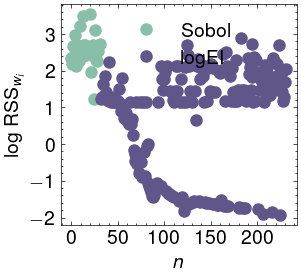

The minimum value of the objective function in log10 scale is -1.9237
Cumulative time for all iterations: 11.6194 seconds


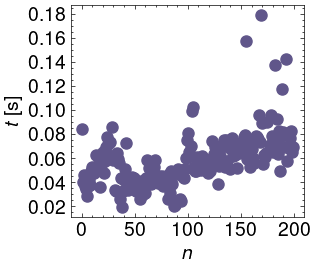

In [14]:
# Plotting the negative of the objective as a function of iterations

# Configure the Figure
plt.figure(figsize=(3, 2.75), constrained_layout=True)

# Prepare Data for Plotting
iterations = np.arange(len(objective_values))             # Array of iteration indices
neg_objective_values = -np.array(objective_values)        # Convert back to original scale by multiplying by -1

# Plot Initial Sobol Samples
plt.plot(
    iterations[:n_initial_points], 
    neg_objective_values[:n_initial_points], 
    'o', 
    markersize=8, 
    label='Sobol', 
    color='#89BFA9'
)

# Plot EI Samples
plt.plot(
    iterations[n_initial_points:], 
    neg_objective_values[n_initial_points:], 
    'o', 
    markersize=8, 
    label='logEI', 
    color='#60568A'
)

# Customize Plot Appearance
#plt.xlim(0, 21)                                          # Set x-axis limit
#plt.ylim(-1, 6)                                        # Uncomment and set y-axis limit if needed
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=14)                                   # X-axis tick label size
plt.yticks(fontsize=14)                                   # Y-axis tick label size
plt.legend(fontsize=14, loc="best")                       # Display legend

# Display the Plot
plt.savefig("fig_ei_relaxation_fish.pdf")                    # Uncomment to save the plot
plt.show()

# Print the Minimum Objective Value
print(f"The minimum value of the objective function in log10 scale is {np.min(neg_objective_values):.4f}")

# Plotting the time per iteration
plt.figure(figsize=(3, 2.75))
plt.plot(times_per_iteration, 'o', markersize=8, color='#60568A')
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$t$ [s]', fontsize=14)           # Y-axis label
plt.xticks(fontsize=14)                                   # X-axis tick label size
plt.yticks(fontsize=14)                                   # Y-axis tick label size
#plt.legend(fontsize=14, loc="best")                       # Display legend

# Printing the cumulative time
print(f"Cumulative time for all iterations: {cumulative_time:.4f} seconds")

## Fitting and Visualizing the Model with Best Parameters from Bayesian Optimization

In this section, we:
1. Define the fractional model evaluator.
2. Extract and print the best parameters obtained from the Bayesian Optimization (BO) phase.
3. Fit the model using the best parameters and compute the model values.
4. Calculate the Residual Sum of Squares (RSS) for the fitted model.
5. Plot the original data, the fitted model from Bayesian Optimization, and the optimized model.


Best parameters from Bayesian Optimization: G = 22128.43, V = 817641.76, alpha = 0.67, beta = 0.11
RSS_w for the Bayesian Optimization model: 0.01192


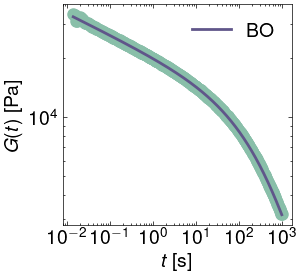

In [15]:
from cycler import cycler  # Import the cycler for customizing plot cycles

# Define model evaluator
fractional_model_name = "FractionalMaxwell"
evaluator = RelaxationEvaluator(model=fractional_model_name)

# Extract the best parameters from Bayesian Optimization phase
best_idx = np.argmax(y_samples)
best_params = X_samples[best_idx]
logG_best, logV_best, alpha_best, beta_best = best_params
G_best_bo = 10 ** logG_best
V_best_bo = 10 ** logV_best

# Print the best parameters from Bayesian Optimization
print("Best parameters from Bayesian Optimization: G = {:.2f}, V = {:.2f}, alpha = {:.2f}, beta = {:.2f}".format(G_best_bo, V_best_bo, alpha_best, beta_best))

# Fit the model with the best parameters from Bayesian Optimization
best_params_no_scale = G_best_bo, V_best_bo, alpha_best, beta_best
bo_model_values = evaluator.compute_model(best_params_no_scale, time, mittag_leffler_type="Pade72")

# Compute the RSS for the Bayesian Optimization model
rss_bo = np.sum(((y_true - bo_model_values) / y_true) ** 2) 
print(f"RSS_w for the Bayesian Optimization model: {rss_bo:.5f}")

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the data, the fitted model from Bayesian Optimization, and the final optimized model
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(time, G_relax, 'o', markersize=8, color='#89BFA9')
plt.plot(time, bo_model_values, '-', color='#60568A', lw=2, label='BO')

# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$ [s]', fontsize=14)
plt.ylabel(r'$G(t)$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# Display the plot
plt.savefig("fig_bo_fit_relaxation_data_fish.pdf")
plt.show()

## Visualizing Surrogate Model Predictions for Different parameter Values

In this section, we:
1. Define a function to predict model outputs on a 2D grid of parameters.
2. Evaluate the model on a grid for various fixed alpha values.
3. Create contour plots for each alpha value showing the predictions of the model.
4. Identify and display the global minima for each alpha value.

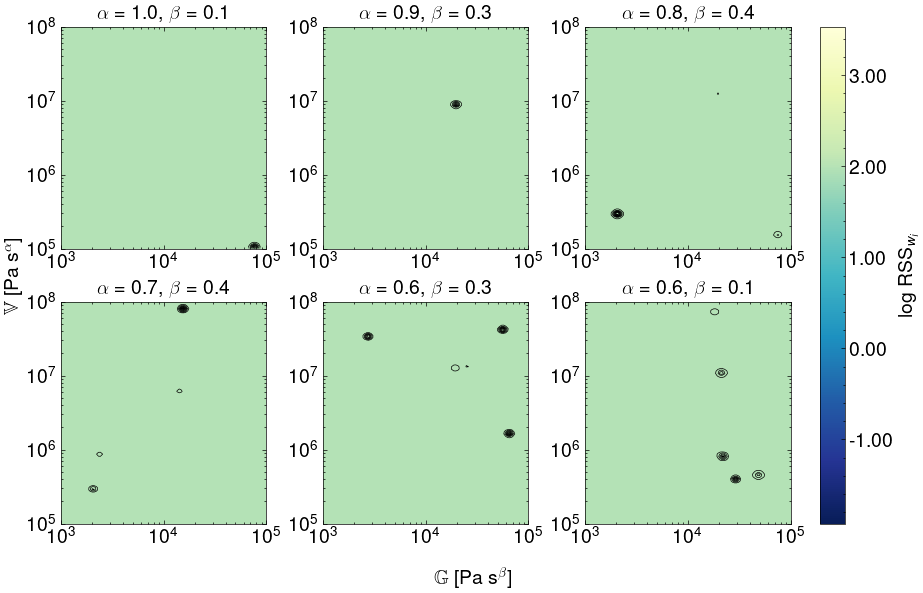

In [16]:
import matplotlib.colors as mcolors

def predict_model_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_1 = model.posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_1

# Define specific (alpha, beta) pairs to plot.
alpha_beta_pairs = [
(1.0, 0.1),
(0.9, 0.3),
(0.8, 0.4),
(0.7, 0.4),
(0.6, 0.3),
(0.6, 0.1)
]

resolution = 100

# Ensure these values are correctly calculated
min_val, max_val = (-max(objective_values), -min(objective_values))

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(9, 5.5), constrained_layout=True)
contours_list = []

global_minima = []  # To store global minima parameters

for ax, (alpha, beta) in zip(axes.flatten(), alpha_beta_pairs):
    logG_grid, logV_grid, preds_obj1 = predict_model_on_grid_2D(model, param_space, alpha, beta, resolution)
    
    # Convert logG and logV to G and V
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()

    # Take negative predictions because of the sign inversion
    neg_preds_obj1 = -1 * scaler.inverse_transform(preds_obj1)
    
    # Find global minima
    min_index = np.unravel_index(neg_preds_obj1.argmin(), neg_preds_obj1.shape)
    global_min_logG = logG_grid[min_index]
    global_min_logV = logV_grid[min_index]
    global_min_G = 10**global_min_logG
    global_min_V = 10**global_min_logV
    global_min_value = neg_preds_obj1[min_index]
    global_minima.append((global_min_G.item(), global_min_V.item(), 10**global_min_value))
    
    # Create the 2D contour plot for Objective 1
    contour = ax.contourf(G, V, neg_preds_obj1, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
    contours_list.append(contour)
    ax.contour(G, V, neg_preds_obj1, levels=10, colors='black', linewidths=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'$\\alpha$ = {alpha}, $\\beta$ = {beta}', fontsize=14)

# Create a ScalarMappable with the same colormap and normalization
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Add a single colorbar for all subplots
cbar = fig.colorbar(sm, ax=axes, location='right', aspect=20, pad=0.02, format='%.2f')
cbar.set_label('$\\log$ RSS$_{w_{i}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add common labels
fig.text(0.5, -0.05, '$\mathbb{G}$ [Pa s$^{\\beta}$]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, '$\mathbb{V}$ [Pa s$^{\\alpha}$]', ha='center', va='center', rotation='vertical', fontsize=14)

# Save the plot and show
plt.savefig("fig_obj1_relaxation_fish.pdf")
plt.show()